# Part 3: Feature Extraction & Visual Interpretability

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader


In [4]:
#Load MNIST CSV
train_path = os.path.expanduser("~/Downloads/MNIST_extracted/MNIST/mnist_train.csv")
test_path  = os.path.expanduser("~/Downloads/MNIST_extracted/MNIST/mnist_test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)
print(test_df.shape)


(60000, 785)
(10000, 785)


In [5]:
class MNISTDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        row = self.data.iloc[idx].values

        label = row[0]
        image = row[1:].reshape(28, 28).astype(np.float32) / 255.0

        image = torch.tensor(image).unsqueeze(0)
        label = torch.tensor(label).long()

        return image, label

train_dataset = MNISTDataset(train_df)
test_dataset = MNISTDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### CNN Model

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = self.pool(x)

        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

cnn_model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)


In [7]:
#Train CNN
epochs = 3

for epoch in range(epochs):

    cnn_model.train()
    running_loss = 0

    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.1700
Epoch 2, Loss: 0.0484
Epoch 3, Loss: 0.0335


In [8]:
#Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

acc = evaluate(cnn_model, test_loader)
print("CNN accuracy:", acc)


CNN accuracy: 98.9


# Question 3.1: The Filter Gallery

In [9]:
filters = cnn_model.conv1.weight.data.clone().cpu()

print(filters.shape)


torch.Size([32, 1, 3, 3])


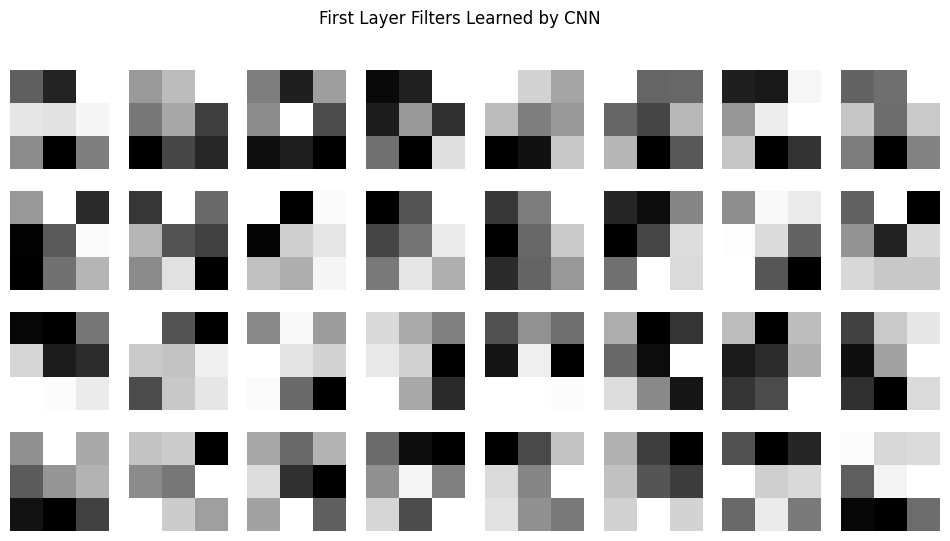

In [10]:
fig, axes = plt.subplots(4, 8, figsize=(12,6))

for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i][0], cmap='gray')
    ax.axis('off')

plt.suptitle("First Layer Filters Learned by CNN")
plt.show()


The first convolution layer learns low-level visual patterns such as
edges, gradients, and simple stroke orientations. These act as the
fundamental building blocks for higher-level feature learning.


# Question 3.2: The Receptive Field Experiment

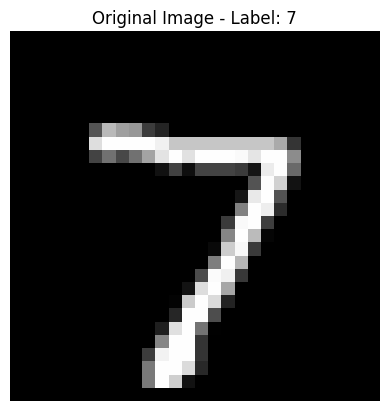

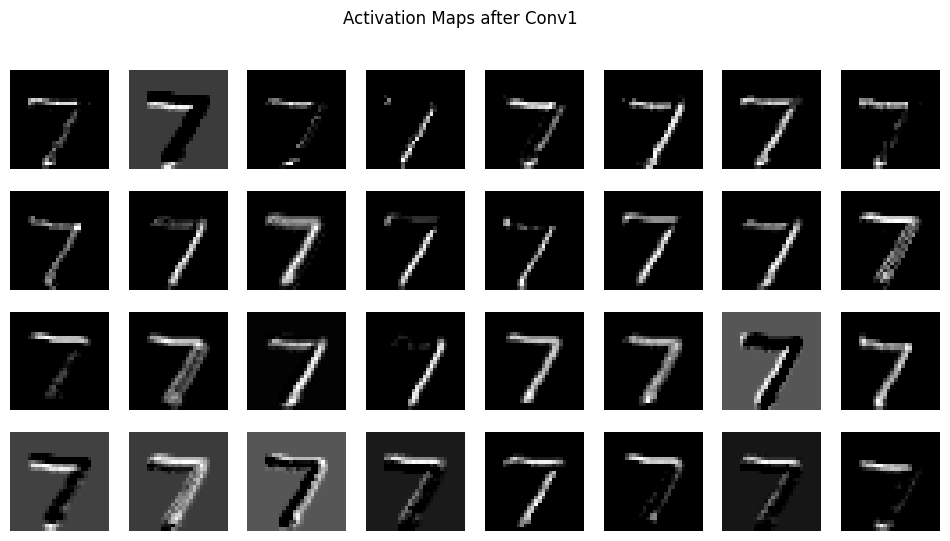

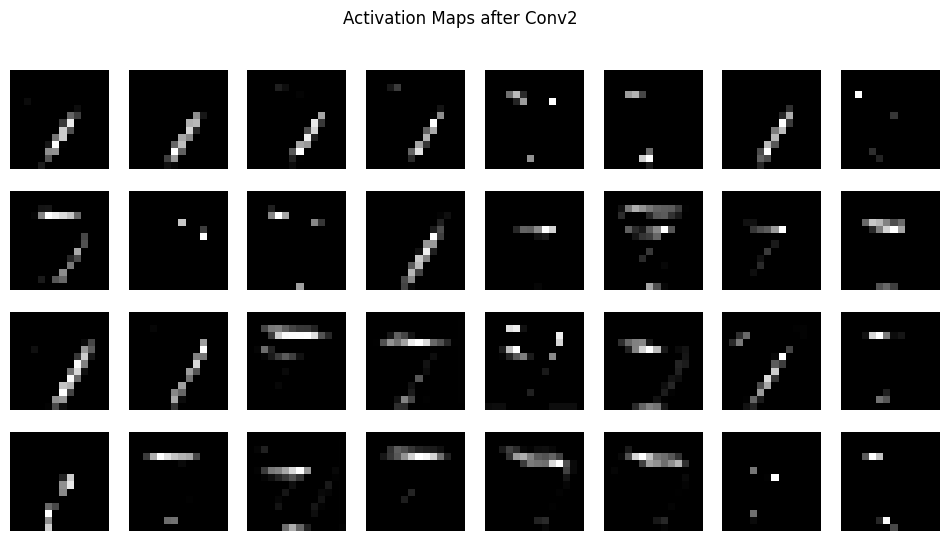

In [11]:
sample_image, label = test_dataset[0]

plt.imshow(sample_image.squeeze(), cmap='gray')
plt.title(f"Original Image - Label: {label}")
plt.axis('off')

#pass through network layers
sample = sample_image.unsqueeze(0).to(device)

# after conv1
act1 = torch.relu(cnn_model.conv1(sample))

# after conv2
act2 = torch.relu(cnn_model.conv2(cnn_model.pool(act1)))

act1 = act1.cpu().detach()
act2 = act2.cpu().detach()

#Visualize activations after conv1
fig, axes = plt.subplots(4, 8, figsize=(12,6))

for i, ax in enumerate(axes.flat):
    ax.imshow(act1[0, i], cmap='gray')
    ax.axis('off')

plt.suptitle("Activation Maps after Conv1")
plt.show()

#Visualize activations after conv2
fig, axes = plt.subplots(4, 8, figsize=(12,6))

for i, ax in enumerate(axes.flat):
    ax.imshow(act2[0, i], cmap='gray')
    ax.axis('off')

plt.suptitle("Activation Maps after Conv2")
plt.show()


Early convolution layers respond strongly to edges and simple strokes
of the digit. These activation maps highlight local features such as
lines and boundaries.

Deeper convolution layers capture more complex spatial structures,
including curves and digit-specific shapes. The network gradually
moves from detecting edges to recognizing full object patterns.

This demonstrates hierarchical feature learning in CNNs.
